# Plot data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress

In [2]:
fs_data=pd.read_csv("fs_summary.csv")

In [3]:
fs_data.head(5)

,sample,n_rep,rf_mean,conc_mean,s_x,CI_low,CI_high,n_add
0,7ppm,3,0.571157,0.125610,0.033122,0.056920,0.194301,NaN
1,80ppm,3,6.725802,1.540749,0.033299,1.471691,1.609808,NaN
2,FS-15N-1,3,1.894745,0.429943,0.032616,0.362302,0.497584,3.75
3,FS-15N-2,3,1.496906,0.338468,0.032737,0.270575,0.406361,3.75
4,FS-15N-3,3,3.035858,0.692320,0.032417,0.625091,0.759548,3.75


In [4]:
#Need to get rid of LFB data
fs_data=fs_data[fs_data['sample'] != '7ppm']
fs_data=fs_data[fs_data['sample'] != '80ppm']

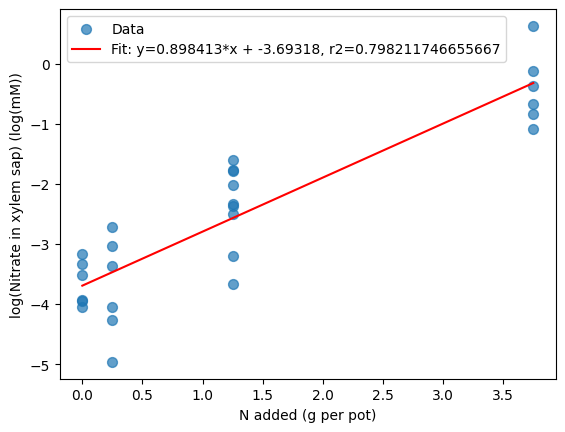

In [5]:
x=fs_data['n_add']
y=np.log(fs_data['conc_mean'])

slope,intercept,r,p,stderr=linregress(x,y)

x_fit = np.linspace(x.min(), x.max(), 200)
y_fit = intercept + slope * x_fit

plt.scatter(x, y, s=50, alpha=0.7, label='Data')
plt.plot(x_fit,y_fit, 'r-', label=f'Fit: y={slope:.6g}*x + {intercept:.6g}, r2={r**2}')
plt.xlabel("N added (g per pot)")
plt.ylabel("log(Nitrate in xylem sap) (log(mM))")
plt.legend()
plt.show()

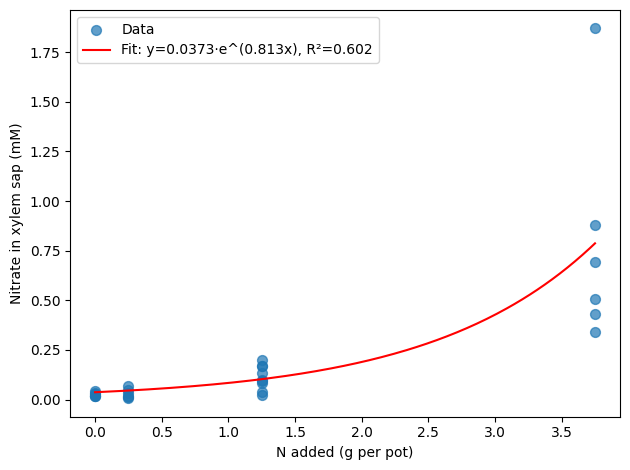

In [6]:
# define exponential model
def expo(x, a, b):
    return a * np.exp(b * x)

# filter to positive concentrations (log undefined for ≤0, and exp fits need >0)
mask = fs_data['conc_mean'] > 0
x = fs_data.loc[mask, 'n_add'].to_numpy()
y = fs_data.loc[mask, 'conc_mean'].to_numpy()

# initial guesses for parameters to help the optimizer
p0 = (y.min(), 0.05)

# fit exponential curve
popt, pcov = curve_fit(expo, x, y, p0=p0)
a, b = popt

# generate smooth x-values for the fitted curve
x_fit = np.linspace(x.min(), x.max(), 200)
y_fit = expo(x_fit, a, b)

residuals = y - expo(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1 - (ss_res / ss_tot)

# plot data and fit
plt.scatter(x, y, s=50, alpha=0.7, label='Data')
plt.plot(x_fit, y_fit, 'r-', label=f'Fit: y={a:.3g}·e^({b:.3g}x), R²={r2:.3f}')
plt.xlabel("N added (g per pot)")
plt.ylabel("Nitrate in xylem sap (mM)")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
ver_data=pd.read_csv("ver_summary.csv")

In [8]:
ver_data.head(5)

,sample,n_rep,rf_mean,conc_mean,s_x,CI_low,CI_high,n_add
0,7ppm,9,0.563018,0.123739,0.021800,0.078529,0.168949,NaN
1,80ppm,9,6.240292,1.429116,0.021689,1.384135,1.474096,NaN
2,V-10N-1,3,0.490702,0.107111,0.033162,0.038338,0.175884,2.5
3,V-10N-2,3,0.323880,0.068754,0.033248,-0.000198,0.137706,2.5
4,V-10N-3,3,0.820131,0.182857,0.033004,0.114410,0.251304,2.5


In [9]:
#Need to get rid of LFB data
ver_data=ver_data[ver_data['sample'] != '7ppm']
ver_data=ver_data[ver_data['sample'] != '80ppm']

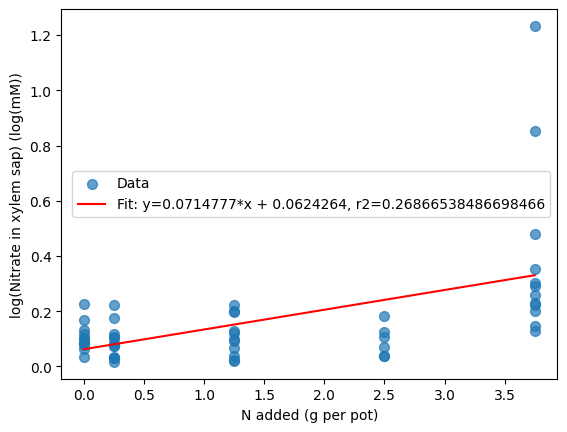

In [11]:
x=ver_data['n_add']
y=ver_data['conc_mean']

slope,intercept,r,p,stderr=linregress(x,y)

x_fit = np.linspace(x.min(), x.max(), 200)
y_fit = intercept + slope * x_fit

plt.scatter(x, y, s=50, alpha=0.7, label='Data')
plt.plot(x_fit,y_fit, 'r-', label=f'Fit: y={slope:.6g}*x + {intercept:.6g}, r2={r**2}')
plt.xlabel("N added (g per pot)")
plt.ylabel("log(Nitrate in xylem sap) (log(mM))")
plt.legend()
plt.show()

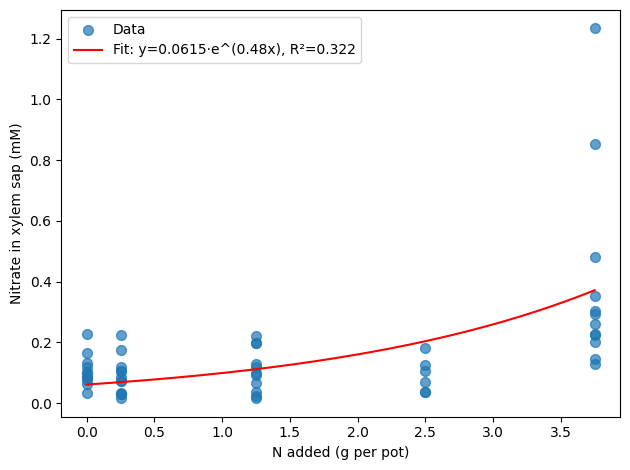

In [12]:
# define exponential model
def expo(x, a, b):
    return a * np.exp(b * x)

# filter to positive concentrations (log undefined for ≤0, and exp fits need >0)
mask = ver_data['conc_mean'] > 0
x = ver_data.loc[mask, 'n_add'].to_numpy()
y = ver_data.loc[mask, 'conc_mean'].to_numpy()

# initial guesses for parameters to help the optimizer
p0 = (y.min(), 0.05)

# fit exponential curve
popt, pcov = curve_fit(expo, x, y, p0=p0)
a, b = popt

# generate smooth x-values for the fitted curve
x_fit = np.linspace(x.min(), x.max(), 200)
y_fit = expo(x_fit, a, b)

residuals = y - expo(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1 - (ss_res / ss_tot)

# plot data and fit
plt.scatter(x, y, s=50, alpha=0.7, label='Data')
plt.plot(x_fit, y_fit, 'r-', label=f'Fit: y={a:.3g}·e^({b:.3g}x), R²={r2:.3f}')
plt.xlabel("N added (g per pot)")
plt.ylabel("Nitrate in xylem sap (mM)")
plt.legend()
plt.tight_layout()
plt.show()